In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from keras.layers import Dense, Flatten, Convolution1D, MaxPooling1D, Dropout, MaxPooling2D, Convolution2D

import json
import matplotlib.pyplot as plt

In [2]:
import random

random.seed(10)

# Carga de datos

In [3]:
train_data = pd.read_csv("data/train_letters.csv")
test_data = pd.read_csv("data/validation_letters.csv")

In [4]:
train_data.head()

,sequence_id,target
0,1,a
1,2,a
2,3,a
3,4,a
4,6,a


# Analisis Exploratorio

In [5]:
print("--------------------Train data--------------------")
print(f"Cantidad de filas : {train_data.shape[0]}")
print(f"Frases unicas : {train_data.target.unique()}")

--------------------Train data--------------------
Cantidad de filas : 128
Frases unicas : ['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's'
 't' 'u' 'v' 'w' 'x' 'y']


In [6]:
print("--------------------Validation data--------------------")
print(f"Cantidad de filas : {test_data.shape[0]}")
print(f"Frases unicas : {test_data.target.unique()}")

--------------------Validation data--------------------
Cantidad de filas : 24
Frases unicas : ['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's'
 't' 'u' 'v' 'w' 'x' 'y']


In [7]:
if (list(train_data.target.unique()) != list(test_data.target.unique())):
    raise ValueError("Error between target and train")

In [8]:
train_data.describe()

,sequence_id
count,128.000000
mean,85.265625
std,50.382706
min,1.000000
25%,43.500000
50%,83.500000
75%,129.250000
max,170.000000


# Preprocesamiento del Modelo

Solo se obtienen 20 indices de las coordenadas x y y, ya que son las unicas que han sido altamente entrenadas del modelo mediapipe de Google

In [9]:
def get_needed_cols():
    cols = []

    for i in range(21):
        # cols.append(f'x_Right_hand_{i}')
        # cols.append(f'y_Right_hand_{i}')
        cols.append(f'x_Left_hand_{i}')
        cols.append(f'y_Left_hand_{i}')
    
    return cols

In [10]:
df = pd.read_csv("data/data_letters.csv")
df_test = df[df['sequence_id'].isin(test_data['sequence_id'])]
df_train = df[df['sequence_id'].isin(train_data['sequence_id'])]

In [11]:
df.head()

,sequence_id,target,x_Left_hand_0,y_Left_hand_0,x_Left_hand_1,y_Left_hand_1,x_Left_hand_2,y_Left_hand_2,x_Left_hand_3,y_Left_hand_3,...,x_Left_hand_16,y_Left_hand_16,x_Left_hand_17,y_Left_hand_17,x_Left_hand_18,y_Left_hand_18,x_Left_hand_19,y_Left_hand_19,x_Left_hand_20,y_Left_hand_20
0,1,a,0.530948,1.0,0.715785,0.944666,0.868372,0.737896,0.921069,0.546306,...,0.544049,0.777359,0.379488,0.578000,0.403089,0.486595,0.425640,0.630759,0.439509,0.707957
1,2,a,0.598715,1.0,0.817269,0.787746,0.907771,0.568508,0.940256,0.383617,...,0.604673,0.687549,0.428759,0.565205,0.488588,0.429457,0.528684,0.529194,0.526195,0.620994
2,3,a,0.699040,1.0,0.855275,0.846713,0.927487,0.655646,0.931123,0.462656,...,0.683310,0.719400,0.607122,0.609145,0.574001,0.512297,0.590989,0.615578,0.620398,0.693777
3,4,a,0.634597,1.0,0.810858,0.903572,0.907139,0.784950,0.954674,0.676814,...,0.645475,0.802731,0.455929,0.711337,0.475522,0.609587,0.522922,0.668138,0.547249,0.736916
4,5,a,0.623369,1.0,0.788632,0.951898,0.908468,0.803502,0.940904,0.680150,...,0.618199,0.885746,0.434740,0.745519,0.459325,0.661971,0.500133,0.754159,0.523836,0.827396


In [12]:
print(len(df))
print(len(df_test) == len(test_data))
print(len(df_train) == len(train_data))

152
True
True


# Modelo

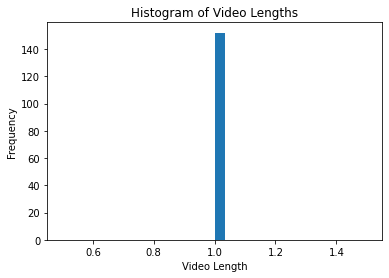

In [13]:
# Compute the lengths of the video sequences
video_lengths = df.groupby('sequence_id').size()
max_seq_length = video_lengths.max()
# max_seq_length = 30
# Plot the histogram
plt.hist(video_lengths, bins=30)  # Adjust the number of bins as needed
plt.xlabel('Video Length')
plt.ylabel('Frequency')
plt.title('Histogram of Video Lengths')
plt.show()

In [14]:
video_lengths.max()

1

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
# Create a one-hot encoder
label_encoder = LabelEncoder()

In [16]:
def padding_videos(df):
    # Create a new DataFrame to store the filled rows
    filled_df = pd.DataFrame()
    target = []


    # Iterate over each group and fill remaining rows with zero
    for _, group in df.groupby('sequence_id'):
        remaining_rows = max_seq_length - len(group)
        zeros_df = pd.DataFrame([[0] * len(group.columns)] * remaining_rows, columns=group.columns)
        zeros_df['sequence_id'] = group['sequence_id'].unique()[0]
        zeros_df['target'] = group['target'].unique()[0]
        group = pd.concat([group, zeros_df])
    
        filled_df = filled_df.append(group)
        target.append(group["target"].unique()[0])
        
    filled_df.reset_index(drop=True, inplace=True)
    filled_df = filled_df.fillna(0)
    return filled_df, target

def padding_labels(target):
    integer_encoded = label_encoder.fit_transform(target)
    integer_encoded = integer_encoded.reshape(-1, 1)

    # Encode the word "Hello"
    onehot_encoder = OneHotEncoder(sparse=False)  # sparse=False to get a numpy array as output
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

In [17]:
X_train, target = padding_videos(df_train)
y_train = padding_labels(target)

In [18]:

del X_train["sequence_id"] 
del X_train["target"] 

print(len(X_train), len(y_train))

128 128


In [19]:
X_test, target = padding_videos(df_test)
y_test = padding_labels(target)
del X_test["sequence_id"] 
del X_test["target"] 

print(len(X_test), len(y_test))

24 24


In [20]:
len(y_train) + len(y_test) == len(df["sequence_id"].unique())

True

In [21]:
len(X_train)

128

In [22]:
# num_samples_train = int(len(X_train)/max_seq_length)
# num_features_train = len(get_needed_cols())
num_classes_train = len(y_train[1])

# X_train = X_train.values.reshape(num_samples_train, max_seq_length, num_features_train)

In [23]:
# X_train = flat_X(X_train)
# X_test = flat_X(X_test)

In [24]:
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (128, 42) (128, 24)
Test: (24, 42) (24, 24)


# Modelo
La entrada son las coordenadas de las manos. Cada video cuenta con n cantidad de filas, 84 columnas (21 columnas por cada coordenada y por ambas manos).
La salida es la frase. La frase se representa por un entero que da el one hot encoder.

Se usa convoluciones para resaltar las caracteristicas en la entrada. Debido a que la entrada son coordenadas normalizadas de un video, se supone que funciona igual que si la entrada fuera una imagen. Estas redes extraen caracteristicas de forma automatica para clasificar objetos luego. Al buscar patrones, se espera que pueda predecir un video que ya ha sido entrenado previamente.

Se reduce el tamaño de la entrada haciendo uso de max pooling y flatten.

Se hace uso de Dense para conectar entradas con salidas.

Se hace uso de Dropout para evitar el sobreajuste.

Relu elimina negativos. 
Sigmoid nos ayuda a obtener la probabilidad de que un ejemplo pertenezca a la clase positiva.
Softmax hace clasificacion multiclase (en nuestro caso las palabras a predecir).

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [26]:
# model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(max_seq_length, num_features_train)))
# model.add(LSTM(128, return_sequences=True, activation='relu'))
# model.add(LSTM(64, return_sequences=False, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(num_classes_train, activation='softmax'))

In [27]:
# # Add input layer with appropriate input shape (84 features)
# model = Sequential()
# model.add(Dense(128, activation='relu', input_shape=(len(get_needed_cols()),)))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))

# # Output layer (adjust units according to your task)
# model.add(Dense(num_classes_train, activation='softmax'))  # For classification, or 'linear' for regression


In [28]:
# Add input layer with appropriate input shape (84 features)
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(len(get_needed_cols()),)))
model.add(Dropout(0.2))  # Adding dropout for regularization
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))  # Adding dropout for regularization
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))  # Adding dropout for regularization

# Output layer (adjust units according to your task)
model.add(Dense(num_classes_train, activation='softmax'))  # For classification, or 'linear' for regression


In [29]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=300, batch_size=8)

# Evaluate the model
score = model.evaluate(X_test, y_test)

# Print the accuracy
print('Test accuracy:', score[1])

Epoch 1/300
16/16 [==============================] - 0s 2ms/step - loss: 3.2345 - accuracy: 0.0156
Epoch 2/300
16/16 [==============================] - 0s 2ms/step - loss: 3.2081 - accuracy: 0.0312
Epoch 3/300
16/16 [==============================] - 0s 1ms/step - loss: 3.1798 - accuracy: 0.0547
Epoch 4/300
16/16 [==============================] - 0s 1ms/step - loss: 3.1725 - accuracy: 0.0469
Epoch 5/300
16/16 [==============================] - 0s 1ms/step - loss: 3.1717 - accuracy: 0.0547
Epoch 6/300
16/16 [==============================] - 0s 1ms/step - loss: 3.1682 - accuracy: 0.0547
Epoch 7/300
16/16 [==============================] - 0s 1ms/step - loss: 3.1223 - accuracy: 0.1016
Epoch 8/300
16/16 [==============================] - 0s 1ms/step - loss: 3.1255 - accuracy: 0.0781
Epoch 9/300
16/16 [==============================] - 0s 1ms/step - loss: 3.1121 - accuracy: 0.1094
Epoch 10/300
16/16 [==============================] - 0s 1ms/step - loss: 3.1077 - accuracy: 0.0781
Epoch 11/

In [30]:
# Get the predictions from the model
predictions = model.predict(X_test)

# Find the most likely prediction for each sample
most_likely_predictions = np.argmax(predictions, axis=1)

1/1 [==============================] - 0s 75ms/step


In [31]:
most_likely_predictions

array([ 0,  1,  2,  3, 11,  5,  6,  7,  8, 19, 10, 11, 12,  4, 14, 15, 16,
       12, 18, 19, 20, 21, 22, 23], dtype=int64)

In [32]:
predicted_labels = label_encoder.inverse_transform(most_likely_predictions)

In [33]:
expected_labels = train_data.target.unique()

In [34]:
correct = 0
for i in range(len(predicted_labels)):
    if (predicted_labels[i] == expected_labels[i]):
        correct += 1
        print("Correctamente predicha: ", predicted_labels[i])

Correctamente predicha:  a
Correctamente predicha:  b
Correctamente predicha:  c
Correctamente predicha:  d
Correctamente predicha:  f
Correctamente predicha:  g
Correctamente predicha:  h
Correctamente predicha:  i
Correctamente predicha:  l
Correctamente predicha:  m
Correctamente predicha:  n
Correctamente predicha:  p
Correctamente predicha:  q
Correctamente predicha:  r
Correctamente predicha:  t
Correctamente predicha:  u
Correctamente predicha:  v
Correctamente predicha:  w
Correctamente predicha:  x
Correctamente predicha:  y


In [35]:
print("Correct >> ", correct)
print("Ratio >> ", str(correct/len(test_data.target.unique())))

Correct >>  20
Ratio >>  0.8333333333333334
